# Metric Learning Model Training

This notebook trains the final `EfficientNetB0` embedding model using the optimal hyperparameters obtained from the Bayesian optimization search in the previous step.

It includes:
- Loading the best-tuned metric learning hyperparameters

- Training the embedding model using Triplet Margin Loss

- Using an MPerClassSampler to structure batches for effective triplet mining

- Training with early stopping based on k-NN validation performance

- Final evaluation on the test set using a k-NN classifier to measure embedding quality (accuracy, F1, precision, recall, confusion matrix)

In [1]:
import sys, os
import copy
import json
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
from torchvision import models
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.samplers import MPerClassSampler

from src.data import get_datasets
from src.train import train_step_metric
from src.utils import set_device, EarlyStopper, evaluate_knn, get_knn_predictions, is_mbconv
from src.visualization import plot_metric_learning_curves, plot_confusion_matrix

## 1. Hyperparameter Setup and General Config

In [2]:
# Define the path to saved optimal hyperparameters
file_path = '../outputs/param-optim-metric/best_metric_hyperparameters.json'

# Open and load the file into a dictionary
with open(file_path, 'r') as f:
    best_params = json.load(f)

print("Loaded Metric Learning Hyperparameters:")
print(best_params)

Loaded Metric Learning Hyperparameters:
{'LEARNING_RATE': 0.0006837454494310736, 'MARGIN': 0.255336275341413, 'EMBEDDING_SIZE': 128, 'UNFREEZE_K': 8}


In [3]:
# -- Settings --
EPOCHS = 5 # Train for more epochs to allow for convergence
DEVICE = set_device()
MODEL_SAVE_PATH = os.path.join("../outputs/models", "best_metric_model.pth")
os.makedirs("../outputs/models", exist_ok=True)

# -- Load Datasets --
datasets = get_datasets(root="../data/augmented_images")
train_ds, val_ds, test_ds = datasets["train"], datasets["val"], datasets["test"]
class_names = train_ds.classes

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")
print(f"Number of classes: {len(class_names)}")

Device: mps
Training samples: 2246
Validation samples: 214
Test samples: 214
Number of classes: 8


In [4]:
# --- Sampler Settings for Metric Learning ---
M_PER_CLASS = 8
BATCH_SIZE = 32

# --- DataLoaders ---
pin_memory = torch.cuda.is_available()
train_sampler = MPerClassSampler(train_ds.targets, m=M_PER_CLASS, length_before_new_iter=len(train_ds))

train_loader = torch.utils.data.DataLoader(train_ds, sampler=train_sampler, batch_size=BATCH_SIZE, pin_memory=pin_memory)
gallery_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=False, pin_memory=pin_memory)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=128, shuffle=False, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=pin_memory)

In [5]:
# --- Model Setup ---
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model.classifier[-1].in_features
model.classifier = nn.Linear(in_features, best_params['EMBEDDING_SIZE'])
model.to(DEVICE)

# --- Progressive Unfreezing Logic ---
# First, freeze all layers in the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Identify all MBConv blocks in the model
mbconv_blocks = [m for m in model.features.modules() if is_mbconv(m)]

# Get the optimal K from our tuned hyperparameters
K = min(best_params['UNFREEZE_K'], len(mbconv_blocks))

# Unfreeze the last K MBConv blocks
print(f"Fine-tuning: Unfreezing the last {K} MBConv blocks.")
for m in mbconv_blocks[-K:]:
    for param in m.parameters():
        param.requires_grad = True

# Always unfreeze the final convolutional block and the classifier
for param in model.features[-1].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

Fine-tuning: Unfreezing the last 8 MBConv blocks.


In [6]:
# --- Metric Learning Components ---
criterion = losses.TripletMarginLoss(margin=best_params['MARGIN'])
miner = miners.TripletMarginMiner(margin=best_params['MARGIN'], type_of_triplets="hard")
optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# --- Initialization ---
history = {
    'train_loss': [], 'train_f1': [],
    'val_acc': [], 'val_f1': []
}
best_model_state = None

# --- Early Stopper ---
# Monitors k-NN validation F1. Overfit gap is not applicable here.
early_stopper = EarlyStopper(mode="max", patience=2, max_overfit_gap=0.2)

## 2. Fine-Tuning the Embedding Model
The model is trained to learn an effective embedding space. Progress is monitored by evaluating a k-NN classifier on the validation set embeddings after each epoch.

Early stopping tracks the validation macro-F1 score and halts training if it fails to improve for 2 consecutive epochs, restoring the best-performing model state.

In [7]:
pbar = tqdm(range(1, EPOCHS + 1), desc="Epochs")

# --- Training Loop ---
for epoch in pbar:
    # --- Training Step ---
    train_metrics = train_step_metric(model, train_loader, criterion, optimizer, miner, DEVICE, scheduler=scheduler)
    
    # --- Validation & Training Evaluation (using k-NN) ---
    val_metrics = evaluate_knn(model, gallery_loader, val_loader, DEVICE)
    
    # Evaluate on the training set to get train_f1
    train_eval_metrics = evaluate_knn(model, gallery_loader, gallery_loader, DEVICE) 

    # --- Update Progress Bar ---
    pbar.set_postfix(
        train_loss=f"{train_metrics['loss']:.3f}",
        train_f1=f"{train_eval_metrics['f1_macro']:.3f}",
        val_f1=f"{val_metrics['f1_macro']:.3f}"
    )

    # --- Store Metrics ---
    history['train_loss'].append(train_metrics['loss'])
    history['train_f1'].append(train_eval_metrics['f1_macro'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1_macro'])

    # --- Early Stopping Check ---
    val_patience_metric = val_metrics["f1_macro"]

    # "Trick" the stopper by passing F1 scores to the loss arguments.
    # To calculate (train_f1 - val_f1), we pass train_f1 as val_loss and val_f1 as train_loss.
    improved, should_stop, reason = early_stopper.step(
        val_patience_metric=val_patience_metric,
        train_metric=val_metrics["f1_macro"],
        val_metric=train_eval_metrics["f1_macro"]
    )

    if improved and not should_stop:
        print(f"\nValidation k-NN F1 improved to {val_patience_metric:.4f}. Saving model state.")
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, MODEL_SAVE_PATH)

    if should_stop:
        # The reason will now specify if it stopped due to patience or overfitting
        print(f"\nEarly stopping triggered after epoch {epoch}: {reason}. Restoring best model.")
        break

# --- Post-Training ---
if best_model_state:
    model.load_state_dict(best_model_state)
else:
    print("Warning: Training finished without further improvement after the first epoch.")
    if not os.path.exists(MODEL_SAVE_PATH):
        torch.save(model.state_dict(), MODEL_SAVE_PATH)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]


Validation k-NN F1 improved to 0.6913. Saving model state.



Early stopping triggered after epoch 2: overfitting gap of 0.2274 exceeded the max of 0.2. Restoring best model.


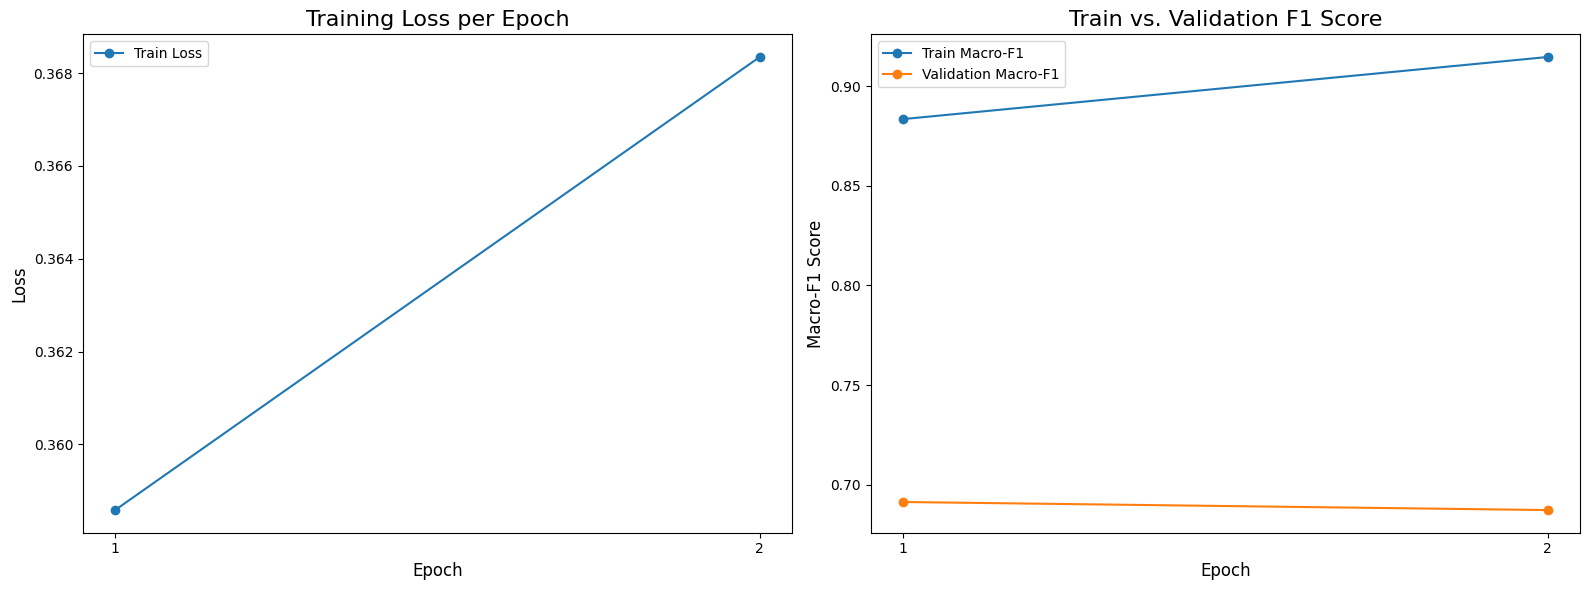

In [8]:
# Plot all curves from the history
plot_metric_learning_curves(history)

Train F1 jumps to ~0.9 in the first epoch, but validation F1 stays ~0.69 and even dips. At the same time, training loss increases, so the loss isn’t aligned with F1 and training looks unstable. Net: the model overfits almost immediately and doesn’t generalize.

## 3. Evaluation on Test Set
With the best model restored, we now evaluate its embedding quality on the unseen test set using the same k-NN classification approach.

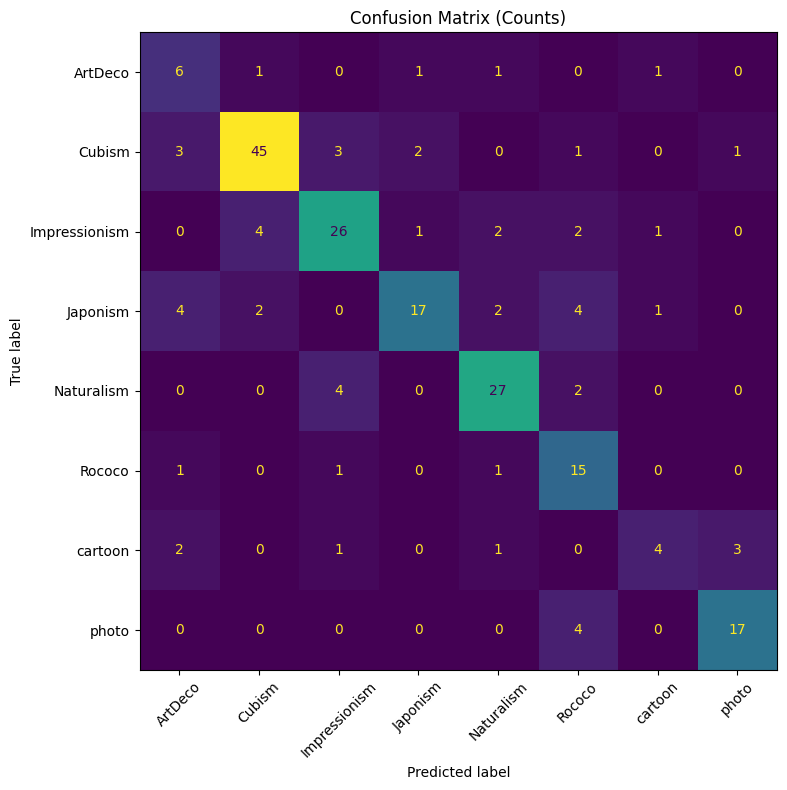

In [9]:
# --- Generate and Plot Confusion Matrix for the Test Set ---
y_true_cm, y_pred_cm = get_knn_predictions(model, gallery_loader, test_loader, DEVICE)

plot_confusion_matrix(y_true_cm, y_pred_cm, class_names)

In [10]:
# --- Get Detailed Statistics on the Test Set ---
report = classification_report(
    y_true_cm, 
    y_pred_cm, 
    target_names=class_names, 
    zero_division=0
)
print(report)

               precision    recall  f1-score   support

      ArtDeco       0.38      0.60      0.46        10
       Cubism       0.87      0.82      0.84        55
Impressionism       0.74      0.72      0.73        36
     Japonism       0.81      0.57      0.67        30
   Naturalism       0.79      0.82      0.81        33
       Rococo       0.54      0.83      0.65        18
      cartoon       0.57      0.36      0.44        11
        photo       0.81      0.81      0.81        21

     accuracy                           0.73       214
    macro avg       0.69      0.69      0.68       214
 weighted avg       0.75      0.73      0.74       214



The final model, trained with metric learning, is evaluated on the test set. Evaluation metricas are worse than for the `EfficientNet-B0` trained as a classifier model. Macro-F1 score equals to 0.68 whole for metric learning model while for the previous model it was 0.77. 

Underrepresented classes are again predicted the worst - ArtDeco and cartoon. I tried to balance the number of underrepresented classes by strong data augmentations but it is still not the same as initially having diverse data for those classes.

A major red flag for the metric learning approach was immediate and severe overfitting; the model stopped improving after just the first epoch.

It is possible that the metric learning approach was unnecessarily complex for this classification task. Since the goal is to classify a fixed number of distinct art styles, a direct classifier is a more straightforward and robust solution. The metric learning model's indirect objective of creating a geometric "embedding space" is more prone to overfitting on this type of problem, especially with the imbalanced dataset.